# 100 Years of Baby Names in British Columbia

Interactive visualizations of baby names in British Columbia from 1915 to 2014. The data includes every first name that was chosen five or more times in a given year, and is published by the British Columbia Vital Statistics Agency. Raw data was downloaded from:

- https://catalogue.data.gov.bc.ca/dataset/most-popular-girl-names-for-the-past-100-years
- https://catalogue.data.gov.bc.ca/dataset/most-popular-boys-names-for-the-past-100-years

In [1]:
from ipywidgets import interact
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter

import utils

In [2]:
data = utils.get_names_data(girls_file='data/bc-popular-girls-names.csv',
                            boys_file='data/bc-popular-boys-names.csv',
                            verbose=True)
data.head()

Loading data/bc-popular-girls-names.csv
Loading data/bc-popular-boys-names.csv
Processing raw data
Merging data
Performing calculations


,Year,Girls Count,Boys Count,Both Count,Girls Yearly Total (All Names),Boys Yearly Total (All Names),Both Yearly Total (All Names),% of Girls,% of Boys,% of Both
Name,,,,,,,,,,
AADEN,1915,0.0,0.0,0.0,4000.0,4470.0,8470.0,0.0,0.0,0.0
AADEN,1916,0.0,0.0,0.0,3587.0,3782.0,7369.0,0.0,0.0,0.0
AADEN,1917,0.0,0.0,0.0,3287.0,3600.0,6887.0,0.0,0.0,0.0
AADEN,1918,0.0,0.0,0.0,3279.0,3549.0,6828.0,0.0,0.0,0.0
AADEN,1919,0.0,0.0,0.0,3441.0,3729.0,7170.0,0.0,0.0,0.0


In [17]:
data[data.index.isin(['JENNIFER', 'JOHN', 'JORDAN', 'MORGAN']) & (data['Year'] == 1995)]

,Year,Girls Count,Boys Count,Both Count,Girls Yearly Total (All Names),Boys Yearly Total (All Names),Both Yearly Total (All Names),% of Girls,% of Boys,% of Both
Name,,,,,,,,,,
JENNIFER,1995,149.0,0.0,149.0,16580.0,19563.0,36143.0,0.898673,0.000000,0.412251
JOHN,1995,0.0,116.0,116.0,16580.0,19563.0,36143.0,0.000000,0.592956,0.320947
JORDAN,1995,31.0,321.0,352.0,16580.0,19563.0,36143.0,0.186972,1.640853,0.973909
MORGAN,1995,71.0,37.0,108.0,16580.0,19563.0,36143.0,0.428227,0.189133,0.298813


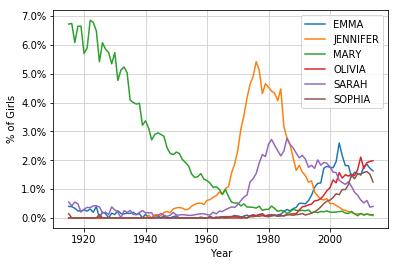

In [58]:
names = ['EMMA', 'JENNIFER', 'MARY', 'OLIVIA', 'SARAH', 'SOPHIA']
metric =  '% of Girls'
df = data.loc[names, ['Year', metric]].reset_index().set_index('Year')
df = df.pivot(columns='Name')
df.columns = df.columns.droplevel(0)
df.columns = sorted(df.columns)

df.plot.line()
plt.ylabel(metric)
plt.gca().yaxis.set_major_formatter(PercentFormatter())
plt.grid(color='0.8')
plt.savefig('scratch/some_girls_names.png')

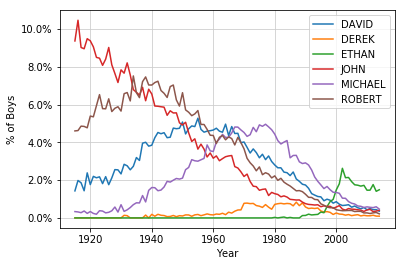

In [71]:
names = ['ROBERT', 'DAVID', 'MICHAEL', 'JOHN', 'ETHAN', 'DEREK']
metric =  '% of Boys'
df = data.loc[names, ['Year', metric]].reset_index().set_index('Year')
df = df.pivot(columns='Name')
df.columns = df.columns.droplevel(0)
df.columns = sorted(df.columns)

df.plot.line()
plt.ylabel(metric)
plt.gca().yaxis.set_major_formatter(PercentFormatter())
plt.grid(color='0.8')
plt.savefig('scratch/some_boys_names.png')

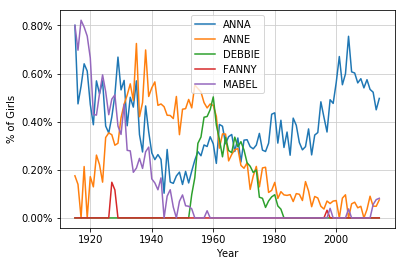

In [73]:
names = ['FANNY', 'ANNE', 'ANNA', 'DEBBIE', 'MABEL']
metric =  '% of Girls'
df = data.loc[names, ['Year', metric]].reset_index().set_index('Year')
df = df.pivot(columns='Name')
df.columns = df.columns.droplevel(0)
df.columns = sorted(df.columns)

df.plot.line()
plt.ylabel(metric)
plt.gca().yaxis.set_major_formatter(PercentFormatter())
plt.grid(color='0.8')
plt.savefig('scratch/fanny_and_others.png')

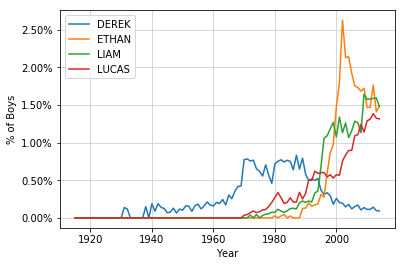

In [74]:
names = ['DEREK', 'LUCAS', 'ETHAN', 'LIAM']
metric =  '% of Boys'
df = data.loc[names, ['Year', metric]].reset_index().set_index('Year')
df = df.pivot(columns='Name')
df.columns = df.columns.droplevel(0)
df.columns = sorted(df.columns)

df.plot.line()
plt.ylabel(metric)
plt.gca().yaxis.set_major_formatter(PercentFormatter())
plt.grid(color='0.8')
plt.savefig('scratch/derek_and_others.png')

In [23]:
cols = ['Girls Count', 'Boys Count', 'Both Count']
sort_by = 'Boys Count'
data[cols].groupby('Name').sum().sort_values(sort_by, ascending=False).head(10)

,Girls Count,Boys Count,Both Count
Name,,,
ROBERT,0.0,38256.0,38256.0
DAVID,0.0,35629.0,35629.0
MICHAEL,0.0,34432.0,34432.0
JOHN,19.0,32598.0,32617.0
JAMES,0.0,30138.0,30138.0
WILLIAM,21.0,27885.0,27906.0
CHRISTOPHER,0.0,19472.0,19472.0
RICHARD,0.0,18827.0,18827.0
DANIEL,0.0,17457.0,17457.0


In [29]:
year = 1915
sort_by = 'Boys Count'
data[data['Year'] == year].sort_values(sort_by, ascending=False).head(10)

,Year,Girls Count,Boys Count,Both Count,Girls Yearly Total (All Names),Boys Yearly Total (All Names),Both Yearly Total (All Names),% of Girls,% of Boys,% of Both
Name,,,,,,,,,,
JOHN,1915,0.0,419.0,419.0,4000.0,4470.0,8470.0,0.0,9.373602,4.946871
WILLIAM,1915,0.0,344.0,344.0,4000.0,4470.0,8470.0,0.0,7.695749,4.061393
GEORGE,1915,0.0,229.0,229.0,4000.0,4470.0,8470.0,0.0,5.123043,2.703660
JAMES,1915,0.0,208.0,208.0,4000.0,4470.0,8470.0,0.0,4.653244,2.455726
ROBERT,1915,0.0,206.0,206.0,4000.0,4470.0,8470.0,0.0,4.608501,2.432113
THOMAS,1915,0.0,124.0,124.0,4000.0,4470.0,8470.0,0.0,2.774049,1.463991
CHARLES,1915,0.0,111.0,111.0,4000.0,4470.0,8470.0,0.0,2.483221,1.310508
ARTHUR,1915,0.0,109.0,109.0,4000.0,4470.0,8470.0,0.0,2.438479,1.286895
EDWARD,1915,0.0,94.0,94.0,4000.0,4470.0,8470.0,0.0,2.102908,1.109799


In [53]:
cols = ['Year', 'Girls Count', 'Boys Count', 'Both Count']
rankings = data[cols].groupby(['Name', 'Year']).rank(ascending=False)
rankings.head()

,Girls Count,Boys Count,Both Count
Name,,,
AADEN,1.0,1.0,1.0
AADEN,1.0,1.0,1.0
AADEN,1.0,1.0,1.0
AADEN,1.0,1.0,1.0
AADEN,1.0,1.0,1.0


In [57]:
year = 1981
metric = 'Girls Count'
series = data.loc[(data['Year'] == year) & (data[metric] > 0), metric]
series.rank(ascending=False).sort_values().head(10)

Name
JENNIFER    1.0
SARAH       2.0
AMANDA      3.0
MELISSA     4.0
LISA        5.0
MICHELLE    6.0
JESSICA     7.0
NICOLE      8.0
ERIN        9.5
CRYSTAL     9.5
Name: Girls Count, dtype: float64

In [56]:
year = 1915
metric = 'Boys Count'
series = data.loc[(data['Year'] == year) & (data[metric] > 0), metric]
series.rank(ascending=False).sort_values().head(10)

Name
JOHN        1.0
WILLIAM     2.0
GEORGE      3.0
JAMES       4.0
ROBERT      5.0
THOMAS      6.0
CHARLES     7.0
ARTHUR      8.0
EDWARD      9.0
DONALD     10.0
Name: Boys Count, dtype: float64